In this course, we will study a particular approach to modeling problems of cognition, intelligence, and statistical inference&mdash;*modeling by simulation*. This approach is also called the *generative approach* and sometimes identified with *Bayesian statistics*. In this approach, we model the world by simulating a simplified version of it. 

To connect our simulation based models with real-world phenomena, it is critical that we correctly handle *uncertainty*. Uncertainty in modeling outcomes arises from a number of sources. We might find that when we go to measure the real world phenomena that we wish to model, our measurements are *noisy*. It might also be the case that simplifications in our model demand that the models be able to handle some amount of uncertainty in order to cover all possible observed datasets. Although it is a deep and hotly debated topic, many researchers also believe that uncertainty is an inherent part of the world in which we live. Whatever the sources of uncertainty, we must capture it to make models that are scientifically useful. 

Our models should be powerful enough to capture a wide variety of different kinds of phenomena from scientific theories of the physical universe to particular sets of  assumptions used in statistical analyses, to models of how people think and act. The most general modeling idiom we have to date is that of the *programming language*. All sufficiently expressive programming languages are equivalent (to Turing machines) and by the Church-Turing thesis, these capture the very notions of *effective computability*. To provide the ability to handle uncertainty, we merely need to add in some probabilistic primitives. Let's look at some examples in Gen. First, let's load the Gen language.

In [1]:
using Gen

# Coin Flipping

The simplest simulation based model, and a standard example for Bayesian statistics, is a coin tossing model. Let's give ourselves a fair coin to make use of. This is known as a *Bernoulli* distribution with parameter $.5$ in probability theory.

In [2]:
bernoulli(0.5)

false

In order to make this useful to the Gen interpreter, we will need to wrap it in a *generative function*. A generative function is a special kind of function that we can use to define probability distributions. We will see much more about these later. For now, just note that a generative function looks like a normal function but it is passed to the `@gen`  macro and allows some special syntax. 

In [25]:
@gen function flip()
    fl ~ bernoulli(0.5)
end


6.929684909748849

This example makes use of the special Gen syntax `val ~ distribution()`. This is called the *sampling operator* and is the heart of how Gen works. The syntax of this operator is modeled on *squiggle notation* from probability theory and statistics, where we often see statements like:

$$x \sim \mathrm{Bernoulli}(0.5)$$

This is read as the random variable $x$ *is distributed as* a Bernoulli random variable with parameter (probability) $0.5$. But it can also be read as the *value* of $x$ is *sampled from* a Bernoulli distribution with probability parameter $0.5$. The sampling operator in Gen has many special properties which we will look at below.

Note that unlike most functions you are familiar with, this function takes no arguments. In functional programming, such functions are called *thunks*. While a deterministic function that takes no arguments must have a constant return value, when our computation can contain  probabilistic choices, this is no longer true.

Now we can call this function to sample different fair coin flips. Here we create an array with the output of `flip` two times.


In [4]:
[flip();flip()]

2-element Array{Bool,1}:
 1
 1

A model which gives an explicit formula for sampling from some distribution  is called a *generative model*. We say that such models are run in the *forward direction*&mdash;the reasons for this will become clear when we introduce inference via conditioning below. In Gen, there is an operator `simulate` which explicitly runs such models in the forward direction. This function additionally  does some book keeping which will become important for understanding how to do inference in probabilistic programming languages.

In [5]:
Gen.simulate(flip,())

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], false, Union{Nothing, Some{Any}}[], ##flip#253, Bool[], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(:fl => Gen.ChoiceOrCallRecord{Bool}(false, -0.6931471805599453, NaN, true)), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}()), false, -0.6931471805599453, 0.0, (), false)

Simulate takes two arguments. First, it takes the generative function you wish to simulate. Second, it takes the tuple of arguments that should be passed to that function when it is run.

Note that unlike a simple call to `flip`, simulate returns a complex *trace* object. We will learn much more about these traces and the information they contain later.

# Biased Coin Flipping

Now let's set up a slightly more complex problem, with some uncertainty built in. We imagine that we are in a setting where we see the result of some number $n$ coin flips; however, we think that the coin may be biased (or bent or weighted) in some way, but we don't know the weight in advance. How can we write a generative process that captures this idea. First, let's give ourselves a useful function called `repeat` that takes a thunk `f` and a number of times to call it repeatedly as inputs and returns a list of the return values of the $n$ calls to `f`.

In [6]:
@gen function repeat(f,n)
  fl = [{:f => i} ~ f() for i in 1:n]
end;

We have used Julia's *array comprehension* syntax which looks like this `[expression for element = iterable]` to create an array of output values.

Note that here we used the sampling operator in a slightly more complex way than before: `{:f => i} ~ f()`. Here the syntax `{:f => i}` gives a *name* to each particular call to `f` in the repeat function. In Julia `=>` is the operator that creates pairs.

In [7]:
typeof(1 => 2)

Pair{Int64,Int64}

And prepending a `:` to a string makes a *symbol*.

In [8]:
:f

:f

In [9]:
typeof(:f)

Symbol

In general, we can name the return values of particular random choices using the syntax `{expression} ~ f()` where `f` is some distribution (generative function). If we wish to also assign the output of the sampling process to a variable, we can use the syntax `x = {expression} ~ f()`. This sampling operator syntax only works in the context of the `@gen` macro, that is, inside of generative function definitions and is specific to Gen, not Julia. 

In [10]:
x = {:x} ~  flip()

LoadError: syntax: { } vector syntax is discontinued around In[10]:1

The syntax `x ~  f()` is shorthand for `x = {:x} ~  flip()`; that is, it assigns the sample value to the variable `x` and gives that particular sample the name of the variable which is the symbol `:x`.

Let's define a generative process for biased coins.

First, to represent uncertainty over the weight of the coin, we will assume that the coins weight is itself drawn from some distribution. A convenient distribution for this is the *beta* distribution. The beta distribution is a distribution on the unit interval. That is, it can be thought of as a distribution on probabilities $p$ and, thus, it is useful for use as a *prior distribution* on our coin weight.

The beta distribution takes two parameters, often called $\alpha$ and $\beta$. Here is a picture (from Wikipedia). 

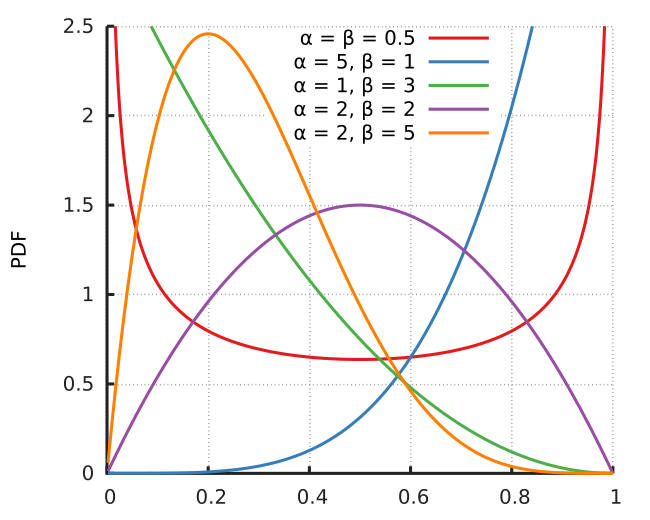

We will talk more about the parameters of a beta distribution later. For now, it suffices to observe that a $beta(1,1)$ distribution is *uniform* on the unit interval.


In [11]:
beta(1,1)

0.062194273761416785

In [29]:
@gen function flip_biased_coin(n)
    weight = {:weight} ~ beta(1,1)
    
    @gen function weighted_coin()
        flip  ~ bernoulli(weight) 
    end
    
    
    flips ~ repeat(weighted_coin, n)
end

t=Gen.simulate(flip_biased_coin,(5,))
Gen.get_choices(t)

│
├── :weight : 0.8726560984903498
│
└── :flips
    │
    └── :f
        │
        ├── 4
        │   │
        │   └── :flip : true
        │
        ├── 2
        │   │
        │   └── :flip : true
        │
        ├── 3
        │   │
        │   └── :flip : true
        │
        ├── 5
        │   │
        │   └── :flip : true
        │
        └── 1
            │
            └── :flip : true


How does the proportion of zeros and ones affect you judgment about the weight of the coin that was tossed?

# Distributions and Random Variables

Before moving on, it is worth saying something about the meaning of some of the terms we will use in this course. Intuitively a *distribution* is just a set of possible outcomes called a *sample space* together with some way of assigning numbers between $0$ and $1$ to those outcomes such that when you add together all of the the probabilities they sum to $1$. In probability theory, this is formalized as a *probability space* which is a triple $\langle \Omega,\mathcal{F},\mu \rangle$ where $\Omega$ is the sample space (for instance, `{true,false}` for our coin flipping example), $\mathcal{F}$ is the *event space* which is just a collection of subsets of $\Omega$ that satisfy certain properties which make $\mathcal{F}$ a $\sigma$-algebra and $\mu$ is the probability measure which assigns probabilities to events in $\mathcal{F}$ (i.e., it assigns probabilities to sets of outcomes in $\Omega$. This function must satisfy a number of properties to be *measurable* and must assign $1$ to all of the outcomes in $\Omega$ taken together and assign a number between $0$ and $1$ to each event otherwise.


This definition is somewhat complicated, and is really only needed to define probability distributions on continuous sets (such as the beta distribution which is defined on the unit interval). When we are talking about discrete distributions (such as a coin), then we can use a simpler definition of a probability distribution that consists of two parts $\langle \Omega,p \rangle$, where $\Omega$ is once again the sample space and $p$ is the *probability mass function* which assigns probabilities (i.e., numbers between $0$ and $1$ to elements of $\Omega$ such that $\sum_{o \in \Omega} p(o) = 1$.

From the probabilistic programming perspective, a distribution can be thought of a generative function&mdash;that is, a function which returns values probabilistically.

Another important concept in probability theory is that of a *random variable*. Intuitively, a random variable is some variable which takes on values according to some distribution. Formally, a random variable is just a measurable function from a distribution to another measurable space. This definition is not particularly intuitive. From a probabilistic programming perspective we can think of a random variable as the **use** of a generative function at a particular place in the evaluation of a program. For instance, `flip` is a distribution. However, in the program below there are $3$ random variables.

In [13]:
[flip(),  flip()]

2-element Array{Bool,1}:
 1
 1

Although both random variables use the same underlying distribution, that is, they are calls to the same generative function, they are distinct random variables and can take on different values in the execution of a program.

One important aspect of the Gen sample operator is it gives us a way of naming particular random variables in code like the above. 


In [14]:
@gen function flip_two()
    [{:flip => i} ~ bernoulli(0.5) for i in 1:2]
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], false, Union{Nothing, Some{Any}}[], ##flip_two#257, Bool[], false)

# Probability Notation

Since probability is a tool used across mathematics, engineering, and
the sciences, there is an array of different notations and conventions
used in different contexts. Here we introduce some of these.

When $X$ is a random variable distributed according to some known
distribution, such as Bernoulli, we often write the following.

$$X \sim \mathrm{Bernoulli}(\theta)$$

As we saw above, this is read $X$ *is distributed as* a Bernoulli distribution with
*parameter* (i.e., `weight`) $\theta$. As we noted, it is also sometimes read
$X$ is *sampled from* a Bernoulli distrinbution with parameter
$\theta$.

Another standard notation is to use $\Pr(X=x)$ to refer to the
probability that random variable $X$ takes on value $x$.

$$\Pr(X=\texttt{true}) = \theta$$


Crucially, $\Pr(\cdot)$ here should be thought of as a higher-order function
which takes a predicate $X=\texttt{true}$  and returns the
probability that that predicate is true. Often lower case $p$ and
$q$ are used to refer to the probability mass functions or densities associated
with random variables, i.e.,

$$\Pr(X=\texttt{true}) = p_{\mathrm{Bern}}(\texttt{true}) = \theta$$

Sometimes we will write $\Pr(X) = \{p(x) \mid x \in X\}$ to refer to the
whole distribution over the random variable $X$ or to the probability evaluated at unspecified values of $X$. For example, $\Pr(X) := \Pr(X=x)$.

# Traces

Now we come to the heart of the bookkeeping that Gen can do for our generative functions. Let's consider the `flip_two` function we just defined. When we call this with simulate, it returns an *execution trace* object. Trace objects record several different pieces of information about the execution of a generative function. One of these pieces of information is 


In [21]:
trace=Gen.simulate(flip_two,())
Gen.get_choices(trace)
#typeof(trace)

│
└── :flip
    │
    ├── 2 : true
    │
    └── 1 : true


By calling the `get_choices` function on the trace, we get a record of the random choices that were executed when the generative function was called. We see here an entry for each element in the list returned by `flip_two`. Since we defined `flip_two` using another generative function, namely `flip` we also see the place where the individual flips were named as `:fl` displayed in this trace.

Computation traces are important because they give us a structured way to talk about all of the random variables which were populated with values in the course of execution of a program. Fundamentally, it is the trace objects which give us a *complete* picture of all of the random choices that are made when we run a model, as well as the arguments of the function, it's return values, and the probability of that program execution.

Let's look at the trace for the `flip_biased_coin` function we defined above.

In [16]:
trace=Gen.simulate(flip_biased_coin, (5,))
Gen.get_choices(trace)

│
├── :weight : 0.9383795986111678
│
└── :flips
    │
    └── :f
        │
        ├── 4
        │   │
        │   └── :flip : true
        │
        ├── 2
        │   │
        │   └── :flip : true
        │
        ├── 3
        │   │
        │   └── :flip : true
        │
        ├── 5
        │   │
        │   └── :flip : true
        │
        └── 1
            │
            └── :flip : true


Note that here, because `flip_biased_coin` itself was defined by composing several generative function, the resulting trace has more structure (and more spurious structure) given by the naming of the various sample statements.

The set of random choices in the particular execution of a generative function are stored in a `ChoiceMap` object and can be thought of as a tree built from pairs. We can address into the choicemap directly by treating the trace object as a dict and giving a path to the relevant node in the choicemap (as a sequence of pairs).



In [17]:
trace[:weight]

0.9383795986111678

In [18]:
trace[:flips=>:f=>4=>:flip]

true

In [19]:
trace[:flips=>:f=>4]

true

Notice that in our traces above, there can be quite a lot of indirection when we make use of multiple generative functions that each assign names to random variables and then call one another. 

For example, we see that the `:flips` node in the trace immediately dominates the `:f` node, but these nodes are redundant&mdash;they only exist because we have named the calls inside of `repeat` with `{:f => i}` and then again named the call to `repeat`.  

We can avoid this with the splice naming operator, which looks like this `var = {*} ~ f()`. This operator tells Gen to splice the result into the calling functions choicemap, rather than give it a separate name to the node itself.

In [20]:
@gen function flip_biased_coin(n)
    weight = {:weight} ~ beta(1,1)
    
    @gen function weighted_coin()
        flip  ~ bernoulli(weight) 
    end
    
    flips = {*} ~ repeat(weighted_coin, n)
end


trace=Gen.simulate(flip_biased_coin, (5,))
Gen.get_choices(trace)

│
├── :weight : 0.7612661498297639
│
└── :f
    │
    ├── 4
    │   │
    │   └── :flip : true
    │
    ├── 2
    │   │
    │   └── :flip : true
    │
    ├── 3
    │   │
    │   └── :flip : true
    │
    ├── 5
    │   │
    │   └── :flip : false
    │
    └── 1
        │
        └── :flip : false


We can see now that the `:flips` node has disappeared.

These examples illustrates another point. The random variable associated with the call to simulate above is a *compound random variable* built from primitive random variables like `flip` and `repeat`. In general, in probabilistic modeling we will often construct complex distributions from simpler ones. We now turn to discussing how such complex *joint distributions* can be constructed from pieces. Before we do that, let's introduce some probability notation.

# Elementary and Compound Distributions and RV

We have now seen how to build several different kinds of distributions in Gen and how these can be used to implement random variables in more complex programs. We have also seen how particular random variables in a program can be named using the sample operator and how the  trace of a generative function represents the set of random variables evaluated during the execution of the function.

There is an important distinction between different kinds of distributions that we use  in our programs. An *elementary distribution* is a distribution that is atomic in the sense that sampling from it does not involve sampling from other, more primitive, random variables. 

We have seen several examples of elementary distributions, such as `bernoulli`. 

In [55]:
bernoulli(0.1)

false

Technically, `bernoulli` actually represents a *family* of distributions, indexed by the weight parameter; that is, `bernoulli(0.5)` is a different distribution from  `bernoulli(0.3)`. 

By contrast with elementary distributions, *compound distributions* are those that are built up from some combination of elementary distributions. We have seen several examples of compound distributions, such as the distribution defined by `flip_biased_coin`.

When we use an elementary/compound distribution in a program, we can also talke about particular random variable which make use of the distribution being elementary or compound.

In general, elementary random variables are instantiated at the leaves of traces, while more complex random variables correspond to higher-level nodes in the trace. In Gen, elementary random variables are sometimes called *choices*.


# Joint Distributions

In probability theory, especially in Bayesian approaches,  the fundamental mathematical object of interest is the *joint distribution*. From the point of view of probabilistic programming, we can think of the joint distribution as the distribution over all possible execution traces of our generative model. That is, it is the distribution over **all** random variables that are instantiated during the execution of our program.

Let's call the $i$th random variable in our execution trace  $X^{(i)}$.  The *joint distribution* over  the trace can be written as follows:

$$\Pr(X^{(1)}, X^{(2)}, \dots, X^{(K)})$$

Where $K$ is the number of random variables in the trace. In fact, traces can contain different numbers of random variables on different executions of the same generative model, as we will see later. But for now let's assume a fixed number of random choices.

What exactly is a joint distribution from a mathematical point of view? First, let's consider the question of what the sample space $\Omega$ is for a given joint distribution. In any given execution of a program there will be some set of elementary random variables which will get instantiated and these will be represented at the leaves of the correponding execution trace. Without loss of generality we can consider the sample space of a joint distribution to be the Cartesian product of the sample spaces for the set of elementary distributions that are instantiated as random variables in different program executions. In other words, the joint sample space is the set of tuples of the form $\langle \bar{X}^{(1)}=x^{(1)}, \dots, \bar{X}^{(n)}=x^{(n)} \rangle$ where the bar overset $\bar{X}$ means that a random variable instantiates an elementary distribution. Consider the example of `flip_two`. This procedure ultimately grounds out in two calls to the `bernoulli(0.5)` distribution. Therefore, 
it's sample space consists of the set of all pairs of booleans: $\{\texttt{true}, \texttt{false} \} \times \{\texttt{true}, \texttt{false} \}$

Note that for practical probabilistic programs, we will generally made use of many compound random variables in our generative models and inference algorithms. It will often be important to name subtrees of the trace that combine multiple elementary random variables. Nevertheless, elementary random variables are the only sources of randomness in our programs; all other computation is deterministic. Thus, a specification of just these random choices will suffice to completely characterize the execution of our program and it is useful to think of our sample space as being defined in terms of tuples of these objects.

What about the probabilities associated with a particular joint distribution? To examine this question, we need to introduce the notion of *statistical independence*.


It is often convenient to visualize joint distributions as a table with one dimension for each
elementary random variable (or coordinate of the tuple). Let's visualise a two 
dimensional joint distribution for `flip_two` this way.

|    $$\mathbf{X}^{(1)}\backslash \mathbf{X}^{(2)}$$  |`true`|`false`|
|---      |---|---|
| `true`  |  $$p(\texttt{true},\texttt{false})$$ |$$p(\texttt{true}, \texttt{true})$$|
| `false` |  $$p(\texttt{true}, \texttt{false})$$ |$$p(\texttt{true},\texttt{false})$$|

Notice that the complexity of a joint distribution increases quickly
as you add values to each random variable  and as you add random variables (i.e., dimensions in the table). For instance, for a sample space of size four, the set of
tuples over two random variables $\Pr(W^{(1)},W^{(2)})$ could have a different
probability for every single one of the $16$ different tuples. For
tuples over three random variables $\Pr(W^{(1)},W^{(2)}, W^{(3)})$ with a
sample space of size $4$ there could be a **different probability** for
each of the $64$ possible strings, and so on.

<!--
What is the probability mass function associated with such a  joint distribution? In general, the probability mass function for a joint distribution needs to specify a probability for every combination of values possible for
the random variables in the distribution. 

$$\Pr(\bar{X}^{(1)} = x^{(1)}, \bar{X}^{(2)} = x^{(2)})$$

So when we construct a random variable out of two Bernoullis, there will be 4 possible *states* in the joint distribution, and when we construct  random variable out of three Bernoullis there will be 8 possible states in the joint. Thus, the full probability mass function $p$ can potentially involve specifying seven probabilities (eight minus one).
-->

<!--

Joint distributions are typically considered the fundamental object of
interest in a probabilistic model since they encode the maximum
possible amount of information about interactions between random
variables. Joint distributions can be very complex and can require
many parameters to specify completely.  Because of this, practical
probabilistic models almost always make simplifying assumptions that
make the representation of the joint distribution less complex, and
prevent us from having to specify a different probability for every
value of every combination of random variables in the table. In
particular, models make *conditional independence assumptions* about
random variables.  For example, in the case of the our `flip_two` model, the
probability mass function is given by the product of the probabilities
of each individual coin flips.

$$\Pr(X^{(1)}, X^{(2)}) = \Pr(X^{(1)}) \times \Pr(X^{(2)})$$

The coin flips in this simple model are *statistically
independent*. Statistical independence is a fundamental concept in
probabilistic modeling, and we will now consider it in more detail.
-->

<!-- TODO: introduce geometric distributions -->


<!--- TODO: conditional probabilities -->



# Independence


Intuitively, *independence* means that the values that one random  variable takes on don't affect our beliefs about the values that another random variable takes on. When sampling from one random variable we are **disallowed** from using the value that another, independent random variable has taken on or, equivalently, we do not **need** this information to take the sample. Mathematically, this idea is captured in probability theory by the following rule: If $A$ and $B$ are *independent random variables*, then we can use the *product rule* of probability theory to compute the joint probability.

$$\Pr(A=a, B=b)=\Pr(A=a)\times \Pr(B=b)$$

More generally, if some set of random variables $X^{(1)}, \dots, X^{(K)}$ are independent from one another then 

$$\Pr(X^{(1)}, \dots, X^{(K)} )= \prod_{i=1}^K \Pr(X^{(i)})$$

When the elementary random variables in a generative model are independent we can use the product rule to calculate the probability of each  *point* or *state* in the joint distribution. Each such point is identified exactly with a single execution trace of the generative model.


This is can be illustrated with our `flip_two` model. In this model, each coin flip is  independent of the other flips. There are four states in the joint, and their probabilities can be computed according to the product rule as follows. 


|    $$\mathbf{X}^{(1)}\backslash \mathbf{X}^{(2)}$$  |`true`|`false`|
|---      |---|---|
| `true`  |  $$p(\texttt{true})\times p(\texttt{false})$$ |$$p(\texttt{true})\times p(\texttt{true})$$|
| `false` |  $$p(\texttt{true})\times p(\texttt{false})$$ |$$p(\texttt{true})\times p(\texttt{false})$$|


We can see the score of a particular trace by using the `Gen.get_score` function. 

In [31]:
trace=Gen.simulate(flip_two, ())
exp(Gen.get_score(trace))

0.25

Since our model uses a fair coin, all individual flip outcomes have probability $0.5$ and, thus, every combination of two outcomes has probability $0.25$.

# Conditional Probabilities

In generative modeling, we build models from *conditional probability distributions*. Conditional probabilities are written like this:

$$\Pr(A=a\mid B=b)$$

Such an expression is read as the probability that random variable $A$ takes on value $a$ *given* or *conditioned on* that the random variable $B$ has taken on the value $b$. 

Critically, the information to the right of the conditioning bar must be some concrete information&mdash;an actual value that $B$ takes on. The conditional distribution is a distribution over $A$ which is *indexed* by that particular value of $B$; thus, there will be a separate distribution over $A$ for each value $B=b$. We can think of the set of conditional distributions indexed by $b$ as a dictionary which contains distributions over $A$ which are hashed on values of $b$. 

More generally, we can consider the joint distribution on some set of random variables $X^{(1)}, \dots, X^{(K)}$ conditioned on another set of random variables taking on some values $Y^{(1)}, \dots, Y^{(N)}$.

$$\Pr(X^{(1)}, \dots, X^{(K)} \mid Y^{(1)}, \dots, Y^{(N)})$$

Here we are using the convention that $\Pr(X \mid Y)$ means $\Pr(X=x \mid Y=y)$ for arbitrary $x$ and $y$.

Conditional probabilities have several (equivalent) interpretations. We can think of them as a sort of hypothetical reasonining: *What would the probability of $A=a$ be if I knew that $B=b$ were true?* This is the most common interpretation when we are considering a conditional probability distribution which is not already given as part of our generative model.

When a conditional distribution is specified as part of the definition of a model, it has another interpretation. In that case, we think of the conditioner as providing specific information which *must* be present in order to draw a sample.

For example, in the `flip_biased_coin` each call to `bernoulli` must be passed a value for `weight`. There is simply no other way to sample the flip&mdash;if you didn't know the value of `weight`, you couldn' draw the sample. 

When we discussed indepedence above we said that random variables were independent if 
when sampling from one random variable we are **disallowed** from using the value that another, independent random variable has taken on or, equivalently, we do not **need** this information to take the sample. In the case of a conditional distribution used in a model, we are instead **required** to use the value of another random variable, and in fact we absolute **need** this information to draw our sample.


# Conditional Independence

Intuitively, *independence* means that the values that one random  variable takes on don't "affect" our beliefs about the values that another random variable takes on. *Conditional independence* refers  to the situation when this is true when some additional information is available.  When sampling from one random variable we don't know the value the other one has taken on, and don't need to, given this side information.  Mathematically, this idea is captured in probability theory by the following rule: If $A$ and $B$ are *conditionally independent random variables given $C$*, then:

$$\Pr(A=a, B=b \mid C=c)=\Pr(A=a \mid C=c)\times \Pr(B=b \mid C=c)$$.

More generally, some set of random variables $X^{(1)}, \dots, X^{(K)}$ are conditionally independent given another set of random variable $Y^{(1)}, \dots, Y^{(N)}$ if

$$\Pr(X^{(1)}, \dots, X^{(K)} \mid Y^{(1)}, \dots, Y^{(N)})= \prod_{i} \Pr(X^{(i)} \mid Y^{(1)}, \dots, Y^{(N)})$$

The set of elementary conditional distributions defining a generative model specifies an ordered sampling scheme on their random variables that allow us to calculate the probability of each  *point* or *state* in the joint distribution. Each such state is specified by an execution trace.

This is can be illustrated with our `flip_biased_coin` model. In this model, each coin flip is conditionally independent of the other flips given the value of `weight`. 

>  Are the random variables representing the individual flips independent without `weight`? Why  or why not?

We can express the probability associated with traces of this model, therefore, using the following elementary conditional probabilities.

$$\Pr(\texttt{weight}) \prod_{i=1}^{n} \Pr(\texttt{flip}_i \mid \texttt{weight})$$

Consider a case where we flip our biased coin only twice after drawing our `weight`. The probability distribution over the possible outcomes is now given by the decomposition in the table below. 


|    $$\mathbf{X}^{(1)}\backslash \mathbf{X}^{(2)}$$  |`true`|`false`|
|---      |---|---|
| `true`  |  $$p(\texttt{weight})p(\texttt{true},\texttt{false} \mid \texttt{weight})$$ |$$p(\texttt{weight})p(\texttt{true}, \texttt{true} \mid \texttt{weight})$$|
| `false` |$$p(\texttt{weight})p(\texttt{true}, \texttt{false} \mid \texttt{weight})$$ |$$p(\texttt{weight})p(\texttt{true},\texttt{false} \mid \texttt{weight})$$|


When specifying a generative model, we are always making use of such a *factorization* of the model into elementary conditional probability distributions. The factorization expresses the *conditional independence assumptions* of the model.  

From a probabilitic programming perspective, such factorizations correspond to the ordered sampling scheme which is specified by the generative function that defines our model. The set of random choices made along the way is given by the trace of the execution of this program. 

Thus, to reiterate, the score of a trace can be computed by taking the product of all the elementary conditional distributions specifying each random choice, in the order they are specified by the generative model.

In [32]:
trace=Gen.simulate(flip_biased_coin, (5,))
exp(Gen.get_score(trace))

0.02646337429149999

In [35]:
trace=Gen.simulate(flip_biased_coin, (1000,))
exp(Gen.get_score(trace))

8.732694686419226e-280

Notice that as we generate more flips, the score of each trace goes down (on average). Why is this?

# The Chain Rule and Conditional Independence

An identity of fundamental importance in probability theory is the so-called *chain rule*. The chain rule gives a way of decomposing a joint distribution over several random variables into a sequence of conditional distributions over individual random variables. For random variables $A$ and $B$, it can be stated as follows.

$$\Pr(A=a, B=b)=\Pr(A=a)\times \Pr(B=b \mid A=a) =\Pr(B=b)\times \Pr(A=a \mid B=b)$$.

Note that this is an exact equality, for any pair of random variables, no additional condition independency assumptions need to be made for this identity to hold.

In general, we can write.

$$\Pr(X^{(1)}, \dots, X^{(K)})= \prod_{i=1}^K \Pr(X^{(\sigma(i))} \mid \{X^{(\sigma(j))}\}_{j=1}^{i-1})$$

Here $\sigma(\cdot)$ is an arbitrary permutation of the indices on the variables. In other words, we can pick any ordering we want for our variables, and the rewrite the joint distribution by writing a product of conditional distributions where each conditional is over just one random variable conditioned on all the random variables that came earlier in the sequence. For example,

$$\Pr(X^{(1)}, \dots, X^{(K)})= \Pr(X^{(1)})\Pr(X^{(2)} \mid X^{(1)}) \Pr(X^{(3)} \mid X^{(1)}, X^{(2)}) \Pr(X^{(4)} \mid X^{(1)}, X^{(2)}, X^{(3)}) \dots$$

This rule, of course, also holds if we also condition on some other random variables throughout.

$$\Pr(X^{(1)}, \dots, X^{(K)} \mid Y^{(1)}, \dots, Y^{(N)})= \prod_{i=1}^K \Pr(X^{(\sigma(i))} \mid \{X^{(\sigma(j))}\}_{j=1}^{i-1}, Y^{(1)}, \dots, Y^{(N)})$$

The chain rule is useful, because it gives a way to think about how to represent a complex joint distribution as a series of distributions which consider each random variable "one at a time" in some particular order.

It is also useful, because when we consider a particular generative model, we can use it to see precisely which conditional independence assumptions our model is making in comparison to the same ordering of variables in the chain decomposition of the joint. For instance, we noted above that the probability of a particular execution trace for a call to `flip_biased_coin(2)` might be given as follows.

$$\Pr(\texttt{weight})\Pr(\texttt{true} \mid \texttt{weight})\Pr(\texttt{false} \mid \texttt{weight})$$ 

The chain rule tells us that the exact represention of the full joint probability, with no conditional independence assumptions  would be given as follows. 


$$\Pr(\texttt{weight},\texttt{true},\texttt{false}) = \Pr(\texttt{weight})\Pr(\texttt{true} \mid \texttt{weight})\Pr(\texttt{false} \mid \texttt{true}, \texttt{weight})$$

By comparing the first and second expressions, we can see that our model makes an important simplifying assumption compared to the full joint&mdash;namely, it treats the coin flips as conditionally independent given the weight of the coin.


# The Full Biased Coin Flipping Model


Let's write out the full biased coin flipping model mathematically. First we repeat the generative function for reference.








In [59]:
@gen function flip_biased_coin(n)
    weight = {:weight} ~ beta(1,1)
    
    @gen function weighted_coin()
        flip  ~ bernoulli(weight) 
    end
    
    
    flips ~ repeat(weighted_coin, n)
end

trace=Gen.simulate(flip_biased_coin, (5,));
Gen.get_choices(trace)

│
├── :weight : 0.9374136622063554
│
└── :flips
    │
    └── :f
        │
        ├── 4
        │   │
        │   └── :flip : true
        │
        ├── 2
        │   │
        │   └── :flip : true
        │
        ├── 3
        │   │
        │   └── :flip : true
        │
        ├── 5
        │   │
        │   └── :flip : true
        │
        └── 1
            │
            └── :flip : true


First in squiggle notation we can write.


$$\theta \sim \mathrm{beta}(\alpha, \beta)$$
$$\{X_i\}_{i=1}^N \sim \mathrm{Bernoulli}(\theta)$$
 
Second, in terms of probability notation.

$$\Pr(\theta \mid \alpha, \beta) \prod_{i=1}^N \Pr(X_i \mid \theta)$$

where

$$\Pr(\theta \mid \alpha, \beta) = p_{\mathrm{beta}}(\theta;\alpha,\beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \theta^{\alpha-1}(1-\theta)^{\beta-1} $$

and

$$\Pr(X \mid \theta) = p_{\mathrm{Bern}}(X;\theta) = \theta$$

Another convenient notation which we will see many times in this course is *graphical model notation*. 

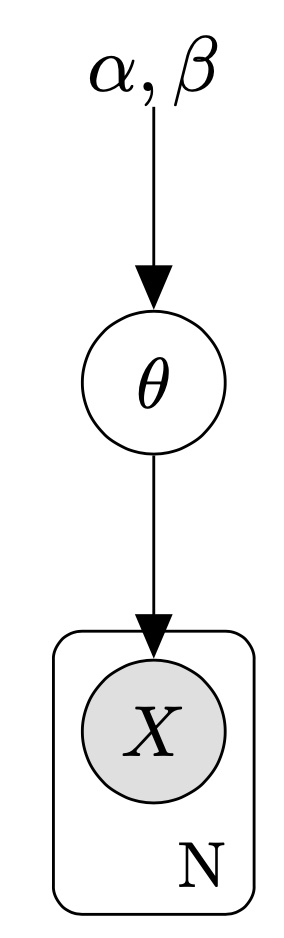
     
Graphical model notation is a compact way of expressing the conditional independence assumptions of a model as a graph with different kinds of nodes. Constants, such as parameters like $\alpha$ and $\beta$ are drawn without a surround node. *Unobserved* or *latent* random variables, such as $\theta$ in this model, are drawn in round nodes that are unshaded. *Observed* random variables, such as $X$, are drawn as greyed out nodes. Finally, this example also uses *plate notation*. The *plate* under the $X$ node means that we sample $X$ $N$ times and each sample is *conditionally independent and identically distributed given* $\theta$, or i.i.d. given $\theta$. The arrows represent the conditional independence assumptions of the model. 

> What would the graphical model look like for the full chain rule decomposition we discussed above?

Note the close relation between the trace and the graphical model. The graphical model displays all of the elementary conditional distributions used to define our model and the dependencies between them. Thus, it is a compact representation of a set of possible traces of our model, suppressing information in the intermediate nodes.